In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.integrate import solve_ivp

***Parallel Reactions in a PFR with Heat Effects***

You can download Fogler's book from here:
https://doku.pub/download/h-scott-fogler-essentials-of-chemical-reaction-engineering-z0x2ze484wqn

1st method

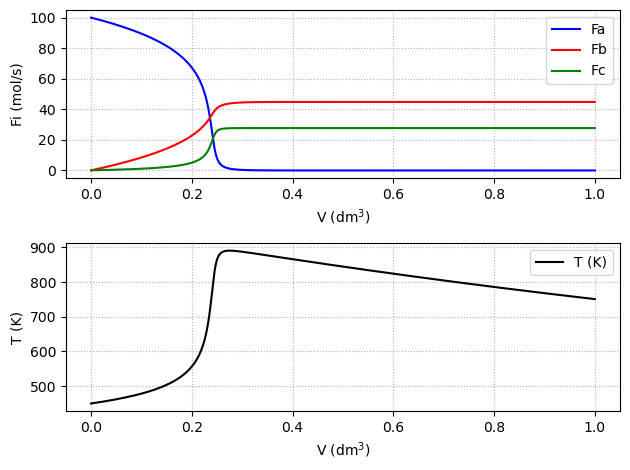

In [2]:
R = 8.314 # J/mol/K

# the rate constant is always temperature dependent
def k(T): 
   
    k1a = 10*np.exp((33256/R)*(1/300-1/T))
    k2a = 0.09*np.exp((74826/R)*(1/300-1/T))
    
    return np.array([k1a, k2a])

# define constant values
Cto = 0.1 # mol/dm3
To = 373 # K
Cpa = 90 # J/mol/K
Cpb = 90 # J/mol/K
Cpc = 180 # J/mol/K
Ua = 4000 # J/m3/sec/K
Ta = 373 # K
dH_r1A = -20000 # J/mol A that reacted in reaction 1
dH_r2A = -60000 # J/mol A that reacted in reaction 2

def odes (V, x):

    # assign each ODE (ordinary differential equation) to a vector element
    # states (2): molar rate for 3 components a, b, c and temperature so we have 4 vector elements
    Fa = x[0]
    Fb = x[1]
    Fc = x[2]
    T = x[3]

    # arrhenius constans
    k1a, k2a = k(T)[0], k(T)[1]
        
    Ft = Fa + Fb + Fc
    Ca = Cto*(Fa/Ft)*(To/T)
    Cb = Cto*(Fb/Ft)*(To/T)
    Cc = Cto*(Fc/Ft)*(To/T)
    
    # reaction rates
    r1a = -k1a*Ca
    r2a = -k2a*Ca**2

    # define each ODE
    dFadV = r1a + r2a
    dFbdV = -r1a
    dFcdV = -r2a/2
    dTdV = (Ua*(Ta-T)+(-r1a)*(-dH_r1A)+(-r2a)*(-dH_r2A))/(Cpa*Fa+Fb*Cpb+Cpc*Fc)

    return np.array([dFadV, dFbdV, dFcdV, dTdV])

# initial conditions for the the dependent variables (4)
x0 = np.array([100, 0.1, 0.1, 450])

# declare a volume vector (volume window) for independent variable
V = np.linspace(0, 1, 10000)

# solution of the ode
sol = solve_ivp(odes, [V[0], V[-1]], x0, t_eval = V)

# unpack the results
Fa, Fb, Fc, T = sol.y

fig, ax = plt.subplots(nrows = 2, dpi = 100)

ax[0].plot(V, Fa, "b-", label = "Fa")
ax[0].plot(V, Fb, "r-", label= "Fb")
ax[0].plot(V, Fc, "g-", label= "Fc")
ax[0].set_ylabel("Fi (mol/s)")
ax[0].set_xlabel("V (dm$^3$)")
ax[0].legend(facecolor='white')
ax[0].grid(linestyle='dotted')

ax[1].plot(V,T, "k-", label= "T (K)")
ax[1].set_ylabel("T (K)")
ax[1].set_xlabel("V (dm$^3$)")
ax[1].legend(facecolor='white')
ax[1].grid(linestyle='dotted')

# check a certain y value for a given x value "10e-04"
# y_value = np.interp(10e-04, V, X)

fig.tight_layout()

2nd method

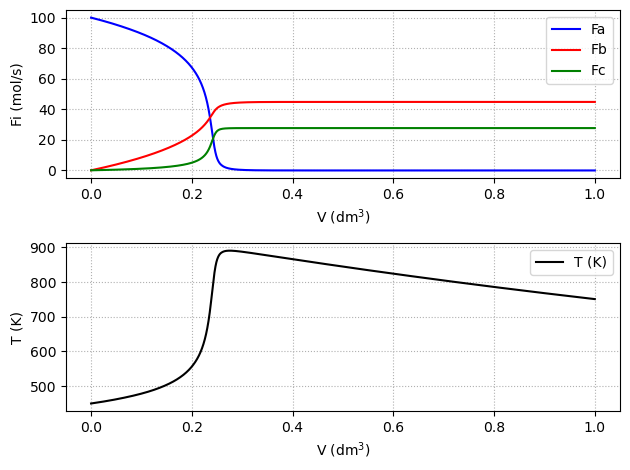

In [3]:
# the rate constant is always temperature dependent
def arr(A, Ea, T):
    
    return A*np.exp((Ea/const.R)*(1/300-1/T))

def simple_reaction(C, k, T):
    
    # rate laws
    r1a = -arr(k[0], k[1], T)*C[0]
    r2a = -arr(k[2], k[3], T)*C[0]**2
    
    # net rates
    ra = r1a + r2a
    rb = -r1a
    rc = -r2a/2
    
    return [ra, rb, rc, r1a, r2a]

def calc_DeltaH(r):
    
    dH_r1 = -20000 # J/mol A that reacted in reaction 1
    dH_r2 = -60000 # J/mol A that reacted in reaction 2
    
    return -r[3] * -dH_r1 - r[4] * -dH_r2

def spec_heat(F):
    
    Cpa = 90 # J/mol/K
    Cpb = 90 # J/mol/K
    Cpc = 180 # J/mol/K
    
    return Cpa*F[0] + F[1] * Cpb + Cpc*F[2]

def odes (V, x, model_param, reaction_model, Cto, Ta, To, Ua):

    F = x[0:-1]
    T = x[-1]
    Ft = F.sum()
    
    C = [Cto*(Fi/Ft)*(To/T) for Fi in F]
    
    # reaction rates
    rate = reaction_model(C, model_param, T)
    
    dF = [r for r in rate]
    dT = (Ua*(Ta-T) + calc_DeltaH(rate))/spec_heat(F)
    
    # define each ODE
    dY = dF[0:3]
    dY.append(dT)

    return dY

# define constant values
Cto = 0.1 # mol/dm3
To = 373 # K
Ta = 373 # K
Ua = 4000 # J/m3/sec/K

# arrhenius parameters k0, Ea set
k = [10, 33256, 0.09, 74826]

# initial conditions for the the dependent variables (4)
x0 = np.array([100, 0.1, 0.1, 450])

# declare a volume vector (volume window) for independent variable
V = np.linspace(0, 1, 10000)

# solution of the od
sol = solve_ivp(odes, [V[0], V[-1]], x0, t_eval = V, args = (k, simple_reaction, Cto, Ta, To, Ua))

# unpack the results
Fa, Fb, Fc, T = sol.y

fig, ax = plt.subplots(nrows = 2, dpi = 100)

ax[0].plot(V, Fa, "b-", label = "Fa")
ax[0].plot(V, Fb, "r-", label= "Fb")
ax[0].plot(V, Fc, "g-", label= "Fc")
ax[0].set_ylabel("Fi (mol/s)")
ax[0].set_xlabel("V (dm$^3$)")
ax[0].legend(facecolor='white')
ax[0].grid(linestyle='dotted')

ax[1].plot(V,T, "k-", label= "T (K)")
ax[1].set_ylabel("T (K)")
ax[1].set_xlabel("V (dm$^3$)")
ax[1].legend(facecolor='white')
ax[1].grid(linestyle='dotted')

fig.tight_layout()